In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from math import floor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

# matplotlib defaults
plt.style.use("fivethirtyeight")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings
warnings.filterwarnings('ignore')


In [3]:
#### List of Attributes for dataset acquired from german.doc
#### good/bad is the label 1 means good customer while 2 means bad
attributes = ["Status_account", "Duration", "Credit_history","Purpose",
             "Credit_amount","Savings_account_bonds","Employment_since","Install_rate",
              "Personal_status_sex","debtors_guarantors","Present_residence_since",
              "Property","Age","Other_install_plans","Housing","No_credits","Job",
              "No_people_liable","Telephone","foreign_worker","good_bad"] 

#### Acquiring dataset from german.data file
df = pd.read_csv("statlog+german+credit+data/german.data", sep=' ', names = attributes)

#### Setting bad to 0 and good to 1
mask_bad = df['good_bad'] == 2
df["good_bad"] = np.where(mask_bad, 0, 1)
df.head()

,Status_account,Duration,Credit_history,Purpose,Credit_amount,Savings_account_bonds,Employment_since,Install_rate,Personal_status_sex,debtors_guarantors,...,Property,Age,Other_install_plans,Housing,No_credits,Job,No_people_liable,Telephone,foreign_worker,good_bad
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,0


**> WORKFLOW**

1. count plots by cat and num_but_cat col
2. point plot by cat and num_Cat with status cols
3. box plot by status vs num col
4. ouliers detection
5. correlation matrix
6. scaling data

> model building:

1. logistic regression
2. SVM
3. k-NN
4. Naive bayes
5. RF XGB

In [4]:
# count plots by cat and num but cat col

def count_plot(var):
    #printing values of variable
    new = df[var].value_counts()
    
    plt.figure(figsize=(8,5))
    sns.countplot(x=var, 
                  data=df)
    plt.grid(visible=True, 
                 color='wheat', 
                 linestyle='--')
    plt.title(var)
    plt.show()
    print("{}:\n{}".format(var,new))

# Baseline Logistic regression model

In [5]:
#### Qualitative attributes that do not require encoding 
to_remove = ["Duration","Credit_amount","Install_rate","Present_residence_since",
             "Age","No_credits","No_people_liable","good_bad"] 

#### Creating the list with the categorical attributes to be encoded
to_be_encoded = attributes.copy()
for el in to_remove:
    to_be_encoded.remove(el)


#### Using One Hot Encoding to transform categorical attributes into qualitative ones
df_encoded = pd.get_dummies(df, columns=to_be_encoded, dtype = int)
# display(df_encoded)


#### Normalization between [0,1] and split into 80% training and 20% test 
scaler = MinMaxScaler()

#### Creation of the pandas dataframe of the normalized values
array_df_encoded = scaler.fit_transform(df_encoded)
df_normalized = pd.DataFrame(array_df_encoded, columns=df_encoded.columns)
df_normalized2 = df_normalized.copy()
df_normalized_no_label = df_normalized.drop(columns="good_bad")


###

#### Splitting the data into sets 
columns_no_label = df_normalized_no_label.columns
X, X_test, y, y_test = train_test_split(
    df_normalized_no_label[columns_no_label], # X
    df_normalized['good_bad'], # y
    stratify = df_normalized['good_bad'], # stratify the dataset based on class labels
    train_size = 0.8, # percentage of training set
    random_state = 50 
)
X.shape, X_test.shape, y.shape, y_test.shape

((800, 61), (200, 61), (800,), (200,))

#### 2.1.1 PCA
---

In [6]:
#### I choose 47 components because I'll be able to describe 100% of the dataset
pca = PCA(n_components = 30)
pca.fit(X)

X_PCA = pca.transform(X)
X_test_PCA = pca.transform(X_test)

In [7]:
# builing logit model using statsmodels api
logit = sm.Logit(y, X)
logit_model = logit.fit()

         Current function value: 0.440451
         Iterations: 35


In [8]:
# significant features
significant_fea = pd.DataFrame(logit_model.pvalues)
significant_fea[significant_fea[0] < 0.05].reset_index()

,index,0
0,Duration,0.007930
1,Credit_amount,0.016720
2,Install_rate,0.000376


In [9]:
# validate with test data

pred_df = pd.DataFrame({"actual": y_test,
                        "Predicted_prob": logit_model.predict(X_test)
                       })

pred_df['Predicted'] = pred_df['Predicted_prob'].map(lambda x: 1 if x>0.5 else 0)
pred_df

,actual,Predicted_prob,Predicted
159,1.0,0.994615,1
276,1.0,0.937829,1
697,1.0,0.963429,1
288,1.0,0.809617,1
98,1.0,0.731812,1
...,...,...,...
198,1.0,0.777029,1
246,1.0,0.945196,1
950,1.0,0.721024,1
979,0.0,0.351274,0


In [10]:
# confusion matrix
def confusion_matri(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    tp, fp, fn, tn = cm.ravel()
    #plot confusion matrix
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='.2f', 
                xticklabels =['Bad credit','Good credit'],
                yticklabels =['Bad credit','Good credit'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted lable')
    plt.title("Confusion Matrix")
    plt.show()
    return tn,fp,fn,tp

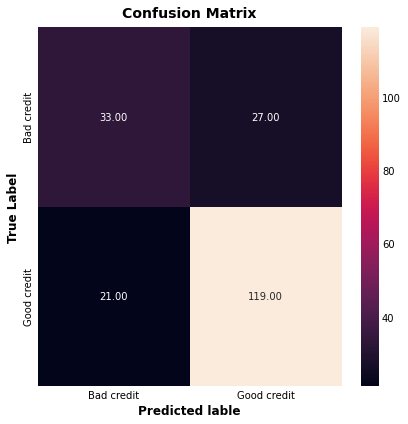

(119, 27, 21, 33)

In [11]:
# confusion matrix of logit model
confusion_matri(pred_df['actual'], pred_df['Predicted'])

- here 1 = good and 0 = bad, TP = bad credit correctky classifed as bad

In [12]:
report = classification_report(pred_df['actual'], pred_df['Predicted'])
print(report)
print("#############################################################")
print("Accuracy score: ", accuracy_score(pred_df['actual'], pred_df['Predicted']))
print("Precision score: ", precision_score(pred_df['actual'], pred_df['Predicted']))

              precision    recall  f1-score   support

         0.0       0.61      0.55      0.58        60
         1.0       0.82      0.85      0.83       140

    accuracy                           0.76       200
   macro avg       0.71      0.70      0.71       200
weighted avg       0.75      0.76      0.76       200

#############################################################
Accuracy score:  0.76
Precision score:  0.815068493150685


- accuracy score is nearly 76% while precision is certainly low compared to accuracy.
- here classes are unbalanced and we are taking decision boundry as a 0.5 which is not resulting in right metrix.
- our cut-off probability shoud be changed.

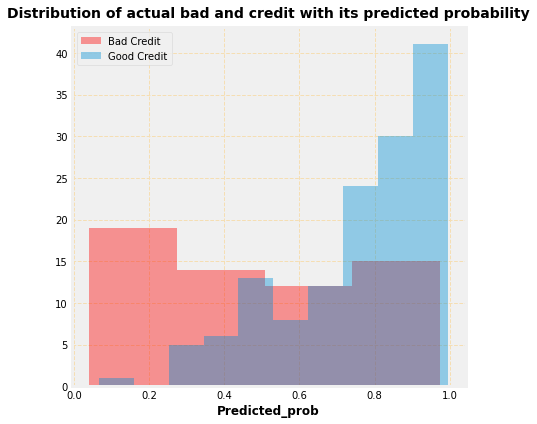

In [13]:
# let's plot actual value of class and predicted probability 
plt.figure(figsize=(6,6))
sns.distplot(pred_df[pred_df['actual']==0]['Predicted_prob'], kde=False,
            label='Bad Credit', color='r')
sns.distplot(pred_df[pred_df['actual']==1]['Predicted_prob'], kde=False,
            label='Good Credit')

plt.title('Distribution of actual bad and credit with its predicted probability')
plt.grid(visible=True, color='wheat', linestyle='--')
plt.legend()
plt.show()

- here you can see that overlap is much higher than it should have been and due unbalanced actuall class distribution our 0.5 cut-off prob is not good.

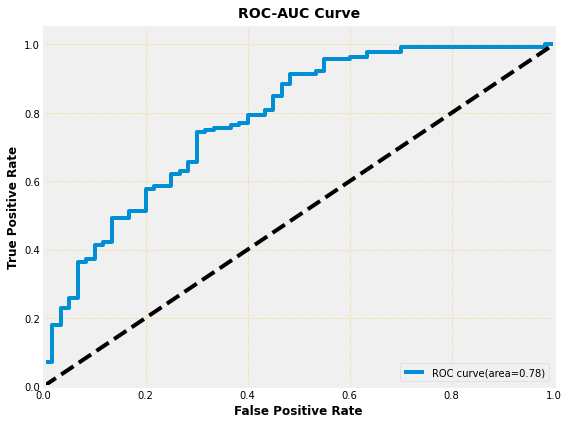

In [14]:
# plotting roc-auc curve
def draw_roc(actual, proba):
    fpr, tpr, thresholds = roc_curve(actual, proba,drop_intermediate=False)
    auc_score = roc_auc_score(actual, proba)
    # plot the curve
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label="ROC curve(area={})".format(round(auc_score,2)))
    plt.plot([0,1],[0,1], 'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(visible=True, color='wheat', linestyle='--')
    plt.legend(loc="lower right")
    plt.title("ROC-AUC Curve")
    plt.show()
    return fpr, tpr, thresholds

# roc-auc curve of logit model
fpr, tpr, thresholds = draw_roc(pred_df['actual'],pred_df['Predicted_prob'])

In [15]:
auc_score = round(roc_auc_score(pred_df['actual'],pred_df['Predicted_prob']),2)
print("AUC score of the model is: ", auc_score)

AUC score of the model is:  0.78


In [16]:
# Youden's index based approch to find cut-off probability 
tpr_fpr = pd.DataFrame({'tpr': tpr,
                       'fpr': fpr,
                       'thresholds': thresholds}
                      )

tpr_fpr['Diff'] = tpr_fpr.tpr - tpr_fpr.fpr
tpr_fpr.sort_values(by='Diff', ascending=False).head()

,tpr,fpr,thresholds,Diff
122,0.742857,0.300000,0.676872,0.442857
121,0.735714,0.300000,0.680852,0.435714
124,0.750000,0.316667,0.663783,0.433333
157,0.914286,0.483333,0.443093,0.430952
120,0.728571,0.300000,0.684171,0.428571


[Add an Explaination](https://medium.com/analytics-vidhya/roc-curve-classification-metrics-why-metrics-cant-replace-your-common-sense-e82d71c12eb3#:~:text=The%20main%20aim%20of%20the,and%20specificity%20can%20be%20maximum.)  

- As per Youden's index maximum difference of tpr and fpr has the actual cutoff probability which **0.37** in this case
- youden's index formula = Max(p) = (sensitivity(p) + specifity(p) - 1)
- Which is nothing but the MAX(TPR-FPR)

Youden's Index, also known as Youden's J statistic, is a statistical measure used to evaluate the effectiveness of a diagnostic test. It is particularly useful in assessing the performance of tests that classify results into two categories, such as positive and negative for a particular condition.

Youden's Index is defined as:

𝐽 = Sensitivity + Specificity − 1


where:

- Sensitivity (also known as the true positive rate) is the proportion of actual positives that are correctly identified by the test.
- Specificity (also known as the true negative rate) is the proportion of actual negatives that are correctly identified by the test. 

The value of Youden's Index ranges from 0 to 1:

- A value of 0 indicates a test with no diagnostic ability (i.e., it is no better than random chance).
- A value of 1 indicates a perfect test with no false positives or false negatives.

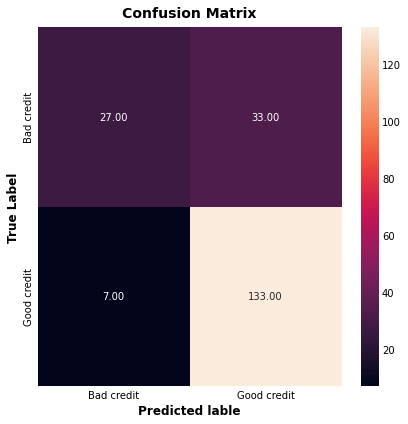

(133, 33, 7, 27)

In [17]:
pred_df['Predicted_new'] = pred_df['Predicted_prob'].map(lambda x: 1 if x>0.37 else 0)

# new confution matrix
confusion_matri(pred_df['actual'], pred_df['Predicted_new'])

In [18]:
new_report = classification_report(pred_df['actual'], pred_df['Predicted_new'])
print(new_report)

print("#######################################################################")

print("Accuracy score: ", accuracy_score(pred_df['actual'], pred_df['Predicted_new']))
print("Precision score: ", precision_score(pred_df['actual'], pred_df['Predicted_new']))

              precision    recall  f1-score   support

         0.0       0.79      0.45      0.57        60
         1.0       0.80      0.95      0.87       140

    accuracy                           0.80       200
   macro avg       0.80      0.70      0.72       200
weighted avg       0.80      0.80      0.78       200

#######################################################################
Accuracy score:  0.8
Precision score:  0.8012048192771084


- Well our model has still performace issues due to unbalanced classes and it still needs some recification.
- We will do oversampling of underbalanced class and build other models to find optimal accuracy of the model.

# RF, SVM, XGB, k-NN, DT, GBC MODELS 

- [Add an Explaination](https://medium.com/metaor-artificial-intelligence/solving-the-class-imbalance-problem-58cb926b5a0f)
- [Add an Explaination](https://medium.com/@okanyenigun/handling-class-imbalance-in-machine-learning-cb1473e825ce)

In [19]:
%%time
# over sample the data
X_n = df_normalized2.drop('good_bad', axis=1)
y_n = df_normalized2['good_bad']

over_sampling = SMOTE(sampling_strategy='minority', random_state=42)
X_n, y_n = over_sampling.fit_resample(X_n,y_n)
print("New balanced classes")
y_n.value_counts()

New balanced classes
CPU times: user 287 ms, sys: 7.28 ms, total: 295 ms
Wall time: 210 ms


good_bad
1.0    700
0.0    700
Name: count, dtype: int64

In [20]:
%%time
# standardize 4 contious cols
# split the train and test
X_trn, X_tst, y_trn, y_tst = train_test_split(X_n, y_n, 
                                              train_size=0.75, 
                                              random_state=42)
# Min Max scaler
scaler = MinMaxScaler()
scaler.fit(X_trn)
X_trn= scaler.transform(X_trn)
X_tst= scaler.transform(X_tst)
X_tst.shape, X_trn.shape, y_trn.shape, y_tst.shape

CPU times: user 27.9 ms, sys: 1.79 ms, total: 29.7 ms
Wall time: 33.7 ms


((350, 61), (1050, 61), (1050,), (350,))

In [21]:
%%time
models_dict = {'RFC': RandomForestClassifier(n_estimators=500, max_depth=15, random_state=42),
               'DT': DecisionTreeClassifier(criterion='entropy', random_state=42,max_depth=20),
               'knn': KNeighborsClassifier(n_neighbors=4),
               'GNB': GaussianNB(),
               'SVC': SVC(C=2.0),
               'GBC': GradientBoostingClassifier(max_depth=2, random_state=42),
               'XGB': XGBClassifier(n_estimators=150, max_leaves=4)}

# fitting models and score
for k,model in models_dict.items():
    model.fit(X_trn,y_trn)
    score = model.score(X_tst,y_tst)
    predict_y = model.predict(X_tst)
    classif_report = classification_report(y_tst,predict_y)
    print("Metrics of Model {}: \n".format(k))
    print("Score of model {} is {}: \n".format(k,round(score,2)))
    print("Classification report of model {} is: \n{}".format(k,classif_report))
    print("###################################################################")

Metrics of Model RFC: 

Score of model RFC is 0.83: 

Classification report of model RFC is: 
              precision    recall  f1-score   support

         0.0       0.80      0.86      0.83       167
         1.0       0.86      0.81      0.83       183

    accuracy                           0.83       350
   macro avg       0.83      0.83      0.83       350
weighted avg       0.83      0.83      0.83       350

###################################################################
Metrics of Model DT: 

Score of model DT is 0.77: 

Classification report of model DT is: 
              precision    recall  f1-score   support

         0.0       0.73      0.81      0.77       167
         1.0       0.81      0.73      0.77       183

    accuracy                           0.77       350
   macro avg       0.77      0.77      0.77       350
weighted avg       0.77      0.77      0.77       350

###################################################################
Metrics of Model knn: 

S

> from above results we can **Random forest classsfier** is the clear winner followed by GBC.

> RF model has the highest accuracy of **84%**

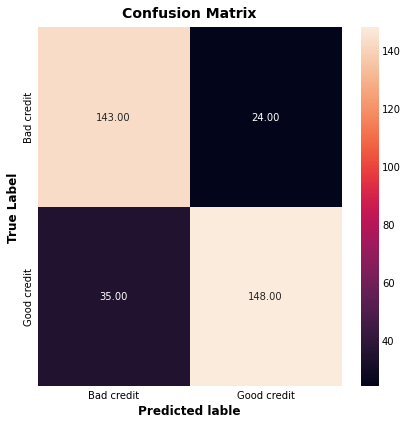

For model RFC (148, 24, 35, 143)
##########################################################


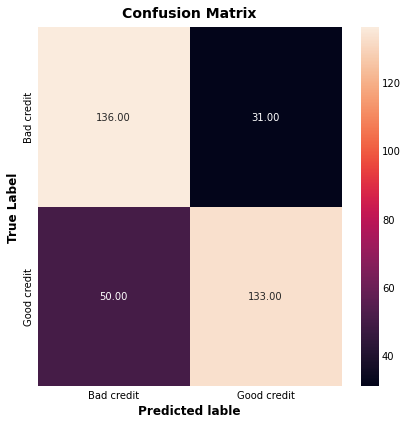

For model DT (133, 31, 50, 136)
##########################################################


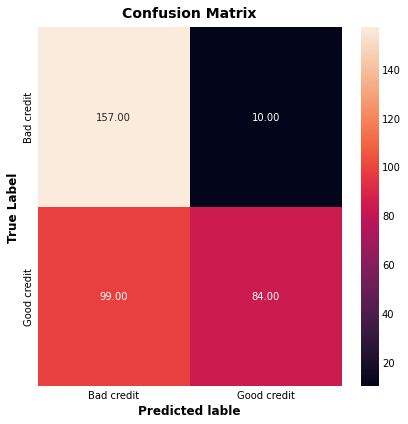

For model knn (84, 10, 99, 157)
##########################################################


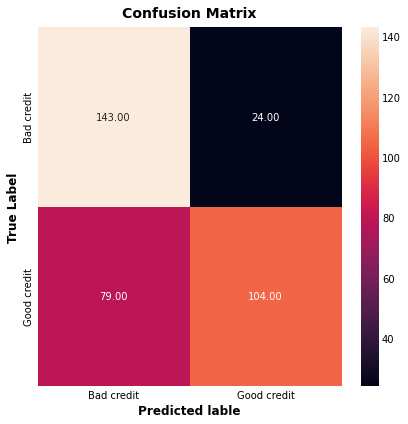

For model GNB (104, 24, 79, 143)
##########################################################


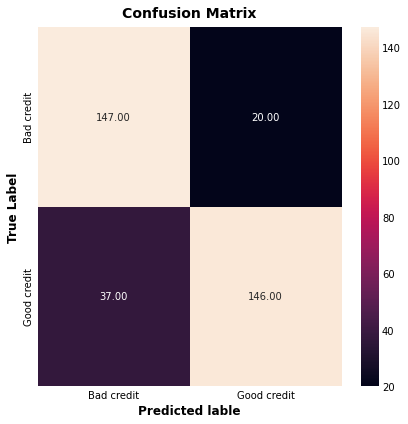

For model SVC (146, 20, 37, 147)
##########################################################


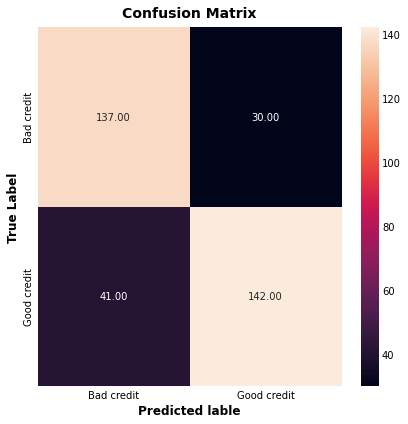

For model GBC (142, 30, 41, 137)
##########################################################


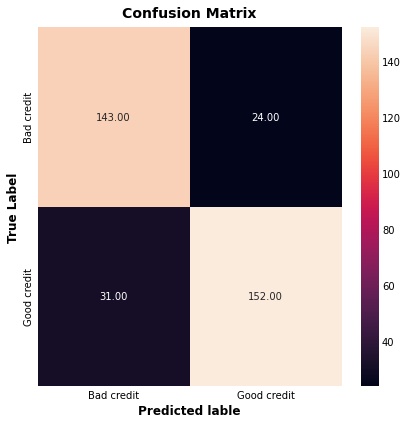

For model XGB (152, 24, 31, 143)
##########################################################


In [22]:
# confusion matrix of all six models
for k,model in models_dict.items():
    score = round(model.score(X_tst,y_tst),2)
    predict_y = model.predict(X_tst)
    cm = confusion_matri(y_tst,predict_y)
    print(f"For model {k}", cm)
    print("##########################################################")

In [23]:
# Accuracy of all the models
for k,model in models_dict.items():
    score = round(model.score(X_tst,y_tst),2)
    predict_y = model.predict(X_tst)
    print(f"Accuracy score of {k}: ", round(accuracy_score(y_tst,predict_y),2))

Accuracy score of RFC:  0.83
Accuracy score of DT:  0.77
Accuracy score of knn:  0.69
Accuracy score of GNB:  0.71
Accuracy score of SVC:  0.84
Accuracy score of GBC:  0.8
Accuracy score of XGB:  0.84
